# Big Data Tools and Methods

# Assignment 3


###      

## Data files

In [1]:
GPA_GRE_FILE="/Users/whitney/Courses/696/Spring19/website/datasets/gpa-gre.csv"
MULTIPLE_SITES = "/Users/whitney/Courses/696/Spring19/website/datasets/multiple-sites.tsv"

#####   

## Problem 1. 

### The dataset GPA-GRE contains 16 years of GPA, Verbal and Quantitative GRE scores for graduate students.

### a. Use linear regression with the combined GRE score (Verbal + Quantitive) as the independent variable and the GPA as the dependent variable to create a model that predicts a students GPA given their combined GRE score.

###      
### Import Statements

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import r2_score

### Linear Regression model

In [3]:
def load_and_process_data():
    # read data
    gpa_gre_df=pd.read_csv(GPA_GRE_FILE)
    
    # create a new column in dataframe for total gre score
    gpa_gre_df['Total']= gpa_gre_df['Verbal'] + gpa_gre_df['Quant']
    
    # remove rows containing null values
    gpa_gre_df=gpa_gre_df[gpa_gre_df.Total.notnull()]
    return gpa_gre_df

In [4]:
## create_model
    
gpa_gre_df = load_and_process_data()
# add dimension using np.newaxis
total_gre_values = (gpa_gre_df['Total']).values[:,np.newaxis]
gpa_values = gpa_gre_df['GPA']
    
# split data into training and testing sets
gre_train, gre_test, gpa_train, gpa_test = train_test_split(total_gre_values, gpa_values, test_size=0.20)
    
# define the linear regression model
model = LinearRegression(fit_intercept=True)
model.fit(gre_train,gpa_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [5]:
def regression_function(model):
 return lambda x: x * model.coef_[0] + model.intercept_

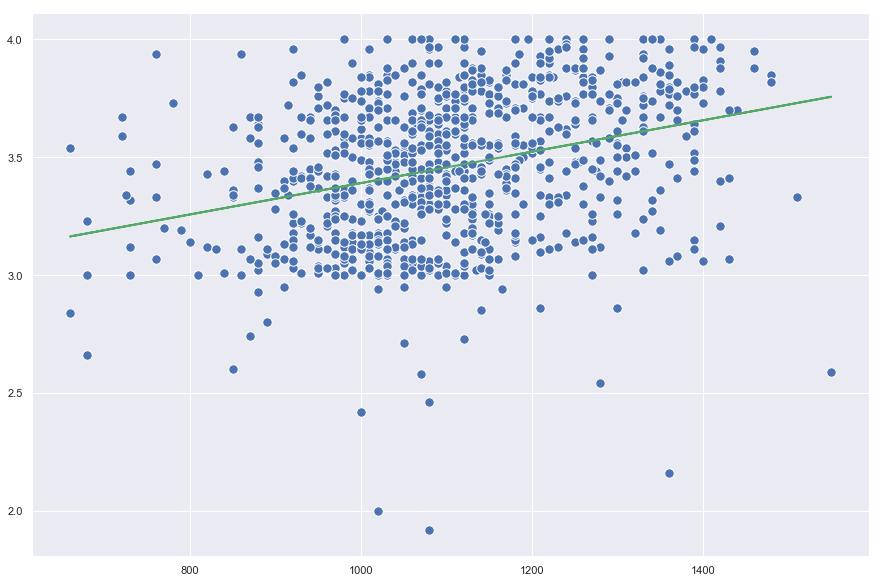

In [6]:
# plot_regression_line
   
regression = regression_function(model)
    
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
    
# plot the linear regression line
plt.scatter(gre_train, gpa_train,s=90,c='b',edgecolor='w')
plt.plot(gre_train, regression(gre_train),c='g',linewidth=2)

 
####    
### b. What is the r2 score of the model?   


In [7]:
## calculate_r2_score
    
r2score = r2_score(gpa_test, model.predict(gre_test))
print("The R2 score of the model:",r2score)

The R2 score of the model: 0.043248834561398164


#####        
### c. Plot the residuals of the data from the model.     

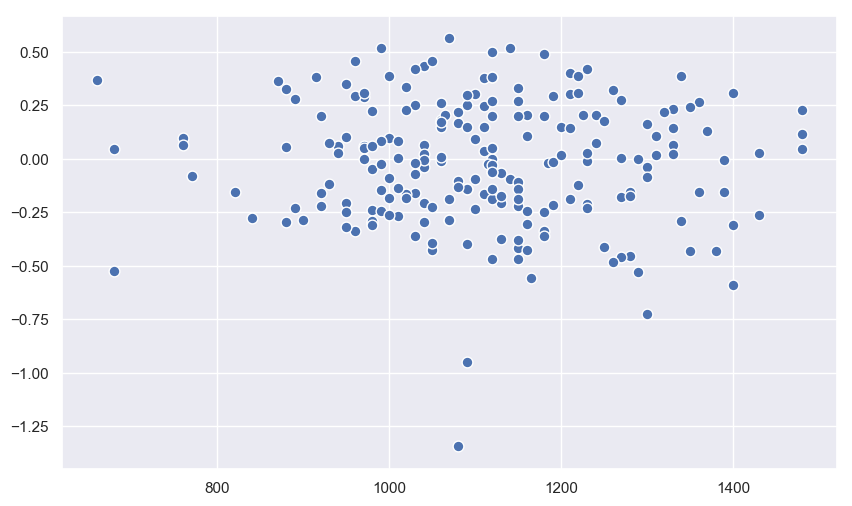

In [12]:
# calculate_residuals


residual = gpa_test - model.predict(gre_test)

plt.figure(figsize=(10,6),dpi=100)

plt.scatter(gre_test,residual,s=60,c='b',edgecolor='w')

##    

## Problem 2

### In the dataset dwell data there is a file multiple-site.tsv. 

### The file contains two columns: a site number and dwell-time on that site. Each site contains multiple entrees.

### Compute the mean and standard deviation of the dwell time per site.

In [8]:
# Load data into pandas dataframe
dwell_df=pd.read_csv(MULTIPLE_SITES, sep='\t',header=0)

In [9]:

# Compute mean and standard deviation
dwell_df['Mean']=dwell_df['dwell-time'].groupby(dwell_df['site']).transform('mean')
dwell_df['Std']=dwell_df['dwell-time'].groupby(dwell_df['site']).transform('std')

# select rows to display unique site numbers and corresponding mean and std
new_df=dwell_df[['site','Mean','Std']].drop_duplicates('site').sort_values(by=['site']) 
new_df.reset_index(drop=True)

,site,Mean,Std
0,0,79.851064,79.135266
1,1,106.000000,103.790126
2,2,88.229167,88.709001
3,3,97.479167,74.814093
4,4,94.333333,77.725843
5,5,102.333333,87.700618
6,6,144.192982,146.930917
7,7,123.367347,117.025584
8,8,94.346939,97.564626
9,9,89.820000,100.470463


###    

###  Using Spark compute the mean and standard deviation of the dwell time per site.

In [10]:
from pyspark.sql import functions as F
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

# start spark session
sc = SparkContext('local')
spark = SparkSession(sc)

# read data into spark dataframe
reader = spark.read
reader.option("header",True)
reader.option("inferSchema",True)
reader.option("sep", "\t")
dw_df = reader.csv(MULTIPLE_SITES)

# compute mean and standard deviation
dw_df.groupBy("site").agg(F.mean('dwell-time').alias('Mean'), F.stddev('dwell-time').alias('Std')).sort('site').show()
sc.stop()

+----+------------------+------------------+
|site|              Mean|               Std|
+----+------------------+------------------+
|   0| 79.85106382978724| 79.13526634363751|
|   1|             106.0|103.79012594607659|
|   2| 88.22916666666667| 88.70900061876551|
|   3| 97.47916666666667|  74.8140928763278|
|   4| 94.33333333333333| 77.72584297816697|
|   5|102.33333333333333|  87.7006178654617|
|   6|144.19298245614036|146.93091654103628|
|   7|123.36734693877551|117.02558371953526|
|   8| 94.34693877551021| 97.56462623572646|
|   9|             89.82|100.47046271193848|
|  10|129.95238095238096| 90.10940569215181|
|  11| 96.98214285714286| 78.94635487501591|
|  12| 80.95081967213115| 68.98729985282513|
|  13| 90.73770491803279|102.01387187360751|
|  14| 74.76470588235294| 78.26278508596386|
|  15|119.34782608695652|107.02050009046641|
|  16| 86.74418604651163|118.83523868570455|
|  17|  77.8913043478261| 83.41388860132467|
|  18| 94.81481481481481| 81.65760870487834|
|  19| 89.

In [ ]:
20/20